# Baryon-Baryon Correlator

First we import stuff, and define all of the objects needed to create/annihilate baryons.  In the future this will be read in from a text file that is generated by some group theory code to construct operators in an automated way.  

In [4]:
import sys
import os

sys.path.append(os.getcwd()[:-9])

from WickContractions.ops.operator import *
from WickContractions.ops.elemental import *
from WickContractions.ops.quarks import *
from WickContractions.ops.commuting import *
from WickContractions.corrs.diagram import *
from WickContractions.wick.utilities import *
from WickContractions.wick.contract import *
from WickContractions.laph.diagram import *

In [5]:
c0=EpsilonTensor(['c0','c1','c2','c3'])
c1=SpinMatrix('X1',['s0','s1'])
c2=SpinMatrix('X2',['s2','s3'])
                  
q0=Quark(False,'u','s0','c0','tf','x1')
q1=Quark(False,'u','s1','c1','tf','x1')
q2=Quark(False,'d','s2','c2','tf','x1')
q3=Quark(False,'d','s3','c3','tf','x1')

c3=EpsilonTensor(['c4','c5','c6','c7'])  
c4=SpinMatrix('X3',['s4','s5'])
c5=SpinMatrix('X4',['s6','s7'])

q4=Quark(False,'u','s4','c4','tf','x1')
q5=Quark(False,'u','s5','c5','tf','x1')
q6=Quark(False,'d','s6','c6','tf','x1')
q7=Quark(False,'d','s7','c7','tf','x1')

annihilate_baryon = Operator([ElementalOperator(1,[c0,c1,c2],[q0,q1,q2,q3])])
annihilate_two_baryons = Operator([ElementalOperator(1,[c0,c1,c2,c3,c4,c5],[q0,q1,q2,q3,q4,q5,q6,q7])])

c6=EpsilonTensor(['c8','c9','c10','c11'])
c7=SpinMatrix('X5',['s8','s9'])
c8=SpinMatrix('X6',['s10','s11'])

q6=Quark(True,'u','s8','c8','ti','x2')
q7=Quark(True,'u','s9','c9','ti','x2')
q8=Quark(True,'d','s10','c10','ti','x2')
q9=Quark(True,'d','s11','c11','ti','x2')

c9=EpsilonTensor(['c12','c13','c14','c15'])
c10=SpinMatrix('X7',['s12','s13'])
c11=SpinMatrix('X8',['s14','s15'])

q10=Quark(True,'u','s12','c12','ti','x2')
q11=Quark(True,'u','s13','c13','ti','x2')
q12=Quark(True,'d','s14','c14','ti','x2')
q13=Quark(True,'d','s15','c15','ti','x2')

create_baryon = Operator([ElementalOperator(1,[c6,c7,c8],[q6,q7,q8,q9])])
create_two_baryons = Operator([ElementalOperator(1,[c6,c7,c8,c9,c10,c11],[q6,q7,q8,q9,q10,q11,q12,q13])])

Now do the contractions and store in Laph subspace

In [7]:
res = contract(annihilate_baryon, create_baryon).diagrams
res2 = contract(annihilate_two_baryons, create_two_baryons).diagrams

print(res2[0])

for i in range(len(res)):
    res[i]=LDiagram(res[i])
for i in range(len(res2)):
    res2[i]=LDiagram(res2[i])
    

1.0 X1_{s0 s1}X2_{s2 s3}X3_{s4 s5}X4_{s6 s7}X5_{s8 s9}X6_{s10 s11}X7_{s12 s13}X8_{s14 s15}eps_{c0 c1 c2 c3}eps_{c12 c13 c14 c15}eps_{c4 c5 c6 c7}eps_{c8 c9 c10 c11}D^{-1}_{u}(x1,tf\mid x2,ti)_{\substack{s0\\c0}\substack{s8\\c8}}D^{-1}_{u}(x1,tf\mid x2,ti)_{\substack{s1\\c1}\substack{s9\\c9}}D^{-1}_{d}(x1,tf\mid x2,ti)_{\substack{s2\\c2}\substack{s10\\c10}}D^{-1}_{d}(x1,tf\mid x2,ti)_{\substack{s3\\c3}\substack{s11\\c11}}D^{-1}_{u}(x1,tf\mid x2,ti)_{\substack{s4\\c4}\substack{s12\\c12}}D^{-1}_{u}(x1,tf\mid x2,ti)_{\substack{s5\\c5}\substack{s13\\c13}}D^{-1}_{d}(x1,tf\mid x2,ti)_{\substack{s6\\c6}\substack{s14\\c14}}D^{-1}_{d}(x1,tf\mid x2,ti)_{\substack{s7\\c7}\substack{s15\\c15}}


In [8]:
print("B->B correlator has {} diagrams".format(len(res)))
print("BB->BB correlator has {} diagrams".format(len(res2)))

B->B correlator has 4 diagrams
BB->BB correlator has 576 diagrams


Now we can apply laph smearing to the quarks.  We print out the B->B diagrams explicitly since there are only four. 

In [12]:
#testing a more generic way to make blocks.
tst=copy.deepcopy(res)
for d in tst:
    d.create_baryon_blocks()
    #d.create_block('delta','M') # should allow this code to handle any number of mesons/baryons
    d.short_props()
    
for d in tst:
    d.create_baryon_source()       # not NC agnostic at the moment.
                                   # not generalized to accomodate mesons + baryons
    print(d)
    print()

1.0 B*(X1,X2,tf)_{0 1 2 3}B(X5,X6,ti)_{8 9 10 11}D^{-1}_{u}(tf,ti)_{0,8}D^{-1}_{u}(tf,ti)_{1,9}D^{-1}_{d}(tf,ti)_{2,10}D^{-1}_{d}(tf,ti)_{3,11}

-1.0 B*(X1,X2,tf)_{0 1 2 3}B(X5,X6,ti)_{8 9 10 11}D^{-1}_{u}(tf,ti)_{1,8}D^{-1}_{u}(tf,ti)_{0,9}D^{-1}_{d}(tf,ti)_{2,10}D^{-1}_{d}(tf,ti)_{3,11}

1.0 B*(X1,X2,tf)_{0 1 2 3}B(X5,X6,ti)_{8 9 10 11}D^{-1}_{u}(tf,ti)_{1,8}D^{-1}_{u}(tf,ti)_{0,9}D^{-1}_{d}(tf,ti)_{3,10}D^{-1}_{d}(tf,ti)_{2,11}

-1.0 B*(X1,X2,tf)_{0 1 2 3}B(X5,X6,ti)_{8 9 10 11}D^{-1}_{u}(tf,ti)_{0,8}D^{-1}_{u}(tf,ti)_{1,9}D^{-1}_{d}(tf,ti)_{3,10}D^{-1}_{d}(tf,ti)_{2,11}



### Quick Check of computation

I just did a quick check of the loop cost and printed out each contraction that needed to be done.  The latter notation is used in Eigen::Tensor or Fastor.

In [10]:
#brute force counting.
costs = {}
for d in tst:
    nested_sums = 0
    for idx in d.commuting[0].indices[0:4]:
        if(idx in d.commuting[1].indices):
            nested_sums+=1
    if nested_sums in costs:
        costs[nested_sums]+=1
    else:
        costs[nested_sums]=1
print('total loops:')
for k,v in costs.items():
    print('  {}*N^{}'.format(v,k))

total loops:
  4*N^0


In [11]:
for d in tst:
    contractions = []
    for i,idx in enumerate(d.commuting[0].indices[0:4]):
        j=d.commuting[1].indices.index(idx)
        contractions.append([i,j])
    print(contractions)

ValueError: '0' is not in list

## Diagram Plots

Just making some quick visuals of the topologies.

1.0 B*(X1,X2,tf,ti)_{8 9 10 11}B(X5,X6,ti)_{8 9 10 11}
-1.0 B*(X1,X2,tf,ti)_{9 8 10 11}B(X5,X6,ti)_{8 9 10 11}
1.0 B*(X1,X2,tf,ti)_{9 8 11 10}B(X5,X6,ti)_{8 9 10 11}
-1.0 B*(X1,X2,tf,ti)_{8 9 11 10}B(X5,X6,ti)_{8 9 10 11}


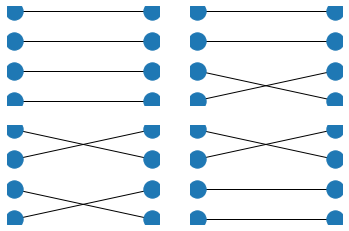

In [13]:
import networkx as nx
import matplotlib.pyplot as plt
import copy

tst=copy.deepcopy(res)
for d in tst:
    d.create_baryon_blocks()
    d.short_props()

for d in tst:
    d.create_baryon_source()
    print(d)
    
G = nx.Graph()
G.add_node('8ti',pos=(1,1))
G.add_node('9ti',pos=(1,2))
G.add_node('10ti',pos=(1,3))
G.add_node('11ti',pos=(1,4))
G.add_node('8tf',pos=(5,1))
G.add_node('9tf',pos=(5,2))
G.add_node('10tf',pos=(5,3))
G.add_node('11tf',pos=(5,4))
pos=nx.get_node_attributes(G,'pos')

xdim = int(len(tst)/2)
ydim = int(len(tst)-len(tst)/2)
for iplt,d in enumerate(tst):
    Gtmp=G.copy()
    pos=nx.get_node_attributes(G,'pos')

    for i,idx in enumerate(d.commuting[0].indices):
        Gtmp.add_edge(idx+d.commuting[0].arguments[2],
                   d.commuting[1].indices[i]+tst[0].commuting[0].arguments[3])
    plt.subplot(xdim,ydim,iplt+1)
    nx.draw(Gtmp,pos)
#plt.savefig('baryon_correlator.png')
plt.show()

In [20]:
import networkx as nx
import matplotlib.pyplot as plt
import copy

tst=copy.deepcopy(res2)
for d in tst:
    d.create_baryon_blocks()
    d.short_props()
    
print(tst[0])

for d in tst:
    d.create_baryon_source()
print(tst[0])

G = nx.Graph()
for i in range(8,16):
    G.add_node(str(i)+'ti',pos=(1,i-8+1))
    G.add_node(str(i)+'tf',pos=(15,i-8+1))
pos=nx.get_node_attributes(G,'pos')

tst=tst[0:int(len(tst)/16)]
    
import math

xdim = int(math.sqrt(len(tst)))
ydim = 0
if(xdim*xdim == len(tst)):
    ydim = xdim
else:
    ydim = xdim+1
if(xdim*ydim<len(tst)):
    xdim+=1
print('subplot lens are xdim={}, ydim={}'.format(xdim,ydim))
plt.figure(figsize=(20,20))
for iplt,d in enumerate(tst):
    Gtmp=G.copy()
    pos=nx.get_node_attributes(G,'pos')

    for i,idx in enumerate(d.commuting[0].indices):
        Gtmp.add_edge(idx+d.commuting[0].arguments[2],
                   d.commuting[3].indices[i]+tst[0].commuting[0].arguments[3])
    for i,idx in enumerate(d.commuting[2].indices):
        Gtmp.add_edge(idx+d.commuting[2].arguments[2],
                   d.commuting[1].indices[i]+tst[0].commuting[2].arguments[3])

    
    plt.subplot(xdim,ydim,iplt+1)
    nx.draw(Gtmp,pos,node_size=30)
#plt.savefig('bb_correlator.png')
plt.show()

1.0 B*(X1,X2,tf)_{0 1 2 3}B*(X3,X4,B,tf)_{4 5 6 7}B(X5,X6,ti)_{8 9 10 11}prop^u(tf,ti)_{0,8}prop^u(tf,ti)_{1,9}prop^d(tf,ti)_{2,10}prop^d(tf,ti)_{3,11}prop^u(tf,ti)_{4,12}prop^u(tf,ti)_{5,13}prop^d(tf,ti)_{6,14}prop^d(tf,ti)_{7,15}
1.0 B*(X1,X2,tf,ti)_{8 9 10 11}B*(X3,X4,B,tf)_{4 5 6 7}B(X5,X6,ti)_{8 9 10 11}prop^u(tf,ti)_{4,12}prop^u(tf,ti)_{5,13}prop^d(tf,ti)_{6,14}prop^d(tf,ti)_{7,15}
subplot lens are xdim=6, ydim=6


IndexError: list index out of range

<Figure size 1440x1440 with 0 Axes>

In [ ]:
print(tst[0])
print(tst[13])

## Contraction optimzier

To optimize the computation, we convert the diagrams into the necessary input for https://github.com/laphnn/contraction_optimizer.

In [4]:
diagrams = []
for d in fulltst:
    contractions = {}
    for i,idx in enumerate(d.ci[0].indices):
        if(idx in d.ci[1].indices):
            j=d.ci[1].indices.index(idx)
            if('01' in contractions):
                contractions['01'].append([i,j])
            else:
                contractions['01']=[[i,j]]
        elif(idx in d.ci[3].indices):
            j=d.ci[3].indices.index(idx)
            if('03' in contractions):
                contractions['03'].append([i,j])
            else:
                contractions['03']=[[i,j]]
    for i,idx in enumerate(d.ci[2].indices):
        if(idx in d.ci[1].indices):
            j=d.ci[1].indices.index(idx)
            if('21' in contractions):
                contractions['21'].append([i,j])
            else:
                contractions['21']=[[i,j]]
        elif(idx in d.ci[3].indices):
            j=d.ci[3].indices.index(idx)
            if('23' in contractions):
                contractions['23'].append([i,j])
            else:
                contractions['23']=[[i,j]]
    diagrams.append(contractions)
    #print(contractions)

NameError: name 'fulltst' is not defined

In [ ]:
codeStr=''
for i,contractions in enumerate(diagrams):
    codeStr+='auto graph{} = Graph({{\n'.format(i)
    for baryons,indices in contractions.items():
        codeStr+='{{{{{},{}}},{{'.format(baryons[0],baryons[1])
        for pair in indices:
            codeStr+='{{{},{}}},'.format(pair[0],pair[1])
        codeStr=codeStr[:-1]
        codeStr+='}},'
    codeStr=codeStr[:-1]
    codeStr+='});'
    
    codeStr+='\n'
print(codeStr)

In [ ]:
diagStr=''
for i,contraction in enumerate(diagrams):
    diagStr+='diagList.push_back(Diagram(graph{},{{0,1,2,3}}));\n'.format(i)
print(diagStr)